<div style="width: 100%; text-align: center; font-size: 40px; font-weight: bold;">
    MINERÍA DE DATOS Y MODELIZACIÓN PREDICTIVA<br>PCA Y CLÚSTERS
</div>
<br>
<div style="width: 100%; text-align: center; font-size: 24px; font-weight: bold;">
    Jacobo Álvarez Gutiérrez
</div>
<br>
El documento que se desarrolla a continuación tiene por objetivo afianzar la aplicación de algunas estrategias de análisis de datos con fines predictivos. Concretamente, se trabajarán en el mismo dos técnicas de análisis: Análisis de Componentes Principales (PCA) y Análisis Clustering. 


La base de datos elegida para llevar a cabo este trabajo es un archivo que lleva por nombre "penguins.xlsx" y que contiene información sobre la especie de pingüino, su lugar de procedencia, la longitud y profundidad del pico, la longitud de la aleta y el género.

<div style="width: 100%; text-align: center; font-size: 32px; font-weight: bold;">
    Preparación del entorno<br>
</div>
<br>

En este apartado vamos a importar las librerías necesarias para la aplicación de todo el código posterior, así como a definir el directorio de trabajo donde se encuentran los datos. Además, realizaremos un proceso de depuración de los datos previo a la aplicación de las diferentes técnicas de análisis predictivo.

In [2]:
# Importación de librerías
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import pdist, squareform
import warnings

# Establecer el nivel de advertencias a "ignore" para ignorar todas las advertencias
warnings.filterwarnings("ignore")

# Definición del directorio de trabajo
#os.chdir(r'C:\Users\jacob\Desktop\master_ucm\mod7_2_mineria_modpredic\Tarea')

# Lectura y visualización inicial del conjunto de datos
datos = pd.read_excel('penguins.xlsx')
datos

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,Male
1,Adelie,Torgersen,39.5,17.4,186,3800,Female
2,Adelie,Torgersen,40.3,18.0,195,3250,Female
3,Adelie,Torgersen,36.7,19.3,193,3450,Female
4,Adelie,Torgersen,39.3,20.6,190,3650,Male
...,...,...,...,...,...,...,...
328,Gentoo,Biscoe,47.2,13.7,214,4925,Female
329,Gentoo,Biscoe,46.8,14.3,215,4850,Female
330,Gentoo,Biscoe,50.4,15.7,222,5750,Male
331,Gentoo,Biscoe,45.2,14.8,212,5200,Female


In [3]:
# Separamos las variables numéricas de las categóricas para poder hacer un tratamiento numérico de los datos
species = datos.iloc[:, [0]]
island = datos.iloc[:, [1]]
sex = datos.iloc[:, [6]]

datos_num = datos.drop(['species', 'island', 'sex'], axis=1)

# Generamos una lista con los nombres de las variables
variables = list(datos_num.columns)

# Generamos a continuación algunos estadísticos descriptivos para observar posibles anomalías
estadisticos = pd.DataFrame({
    'Mínimo': datos_num[variables].min(),
    'Percentil 25': datos_num[variables].quantile(0.25),
    'Mediana': datos_num[variables].median(),
    'Percentil 75': datos_num[variables].quantile(0.75),
    'Media': datos_num[variables].mean(),
    'Máximo': datos_num[variables].max(),
    'Desviación Estándar': datos_num[variables].std(),
    'Varianza': datos_num[variables].var(),
    'Datos Perdidos': datos_num[variables].isna().sum()  # Cuenta los valores NaN por variable.
})
estadisticos

,Mínimo,Percentil 25,Mediana,Percentil 75,Media,Máximo,Desviación Estándar,Varianza,Datos Perdidos
bill_length_mm,32.1,39.5,44.5,48.6,43.992793,59.6,5.468668,29.906333,0
bill_depth_mm,13.1,15.6,17.3,18.7,17.164865,21.5,1.969235,3.877888,0
flipper_length_mm,172.0,190.0,197.0,213.0,200.966967,231.0,14.015765,196.441677,0
body_mass_g,2700.0,3550.0,4050.0,4775.0,4207.057057,6300.0,805.215802,648372.487699,0


De un análisis somero de los descriptivos previamente generados, podemos comprobar que los datos ya están suficientemente depurados. Por un lado, vemos que ninguna de las variables con las que vamos a trabajar tiene valores perdidos. Además, se aprecia una cercanía adecuada entre los valores de la mediana y de la media en cada una de las variables, así que parece que tampoco tenemos demasiados valores atípicos.

Para concluir y pasar directamente al análisis de componentes principales debemos estudiar, en primer lugar, la matriz de covarianzas y la de correlaciones entre las variables. Esto nos dirá, por un lado, si esta base de datos es susceptible de aplicarle una técnica PCA y, por otro, nos ayudará a entender cómo están relacionadas las variables entre sí. Además, para la matriz de correlaciones se aplicará también una representación gráfica con un mapa de calor.

In [5]:
# Matriz de covarianzas
covarianzas = datos_num.cov()
covarianzas

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,29.906333,-2.462091,50.058195,2595.623304
bill_depth_mm,-2.462091,3.877888,-15.947248,-748.456122
flipper_length_mm,50.058195,-15.947248,196.441677,9852.191649
body_mass_g,2595.623304,-748.456122,9852.191649,648372.487699


In [6]:
#Matriz de correlaciones
correlaciones = datos_num.corr()
correlaciones

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.228626,0.653096,0.589451
bill_depth_mm,-0.228626,1.000000,-0.577792,-0.472016
flipper_length_mm,0.653096,-0.577792,1.000000,0.872979
body_mass_g,0.589451,-0.472016,0.872979,1.000000


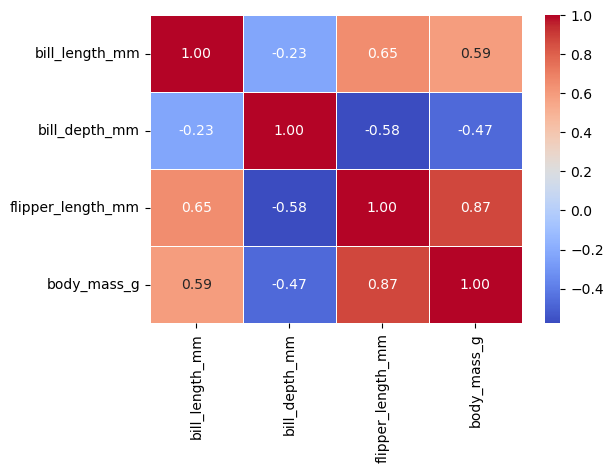

In [7]:
# Mapa de calor de la matriz de correlaciones
plt.figure(figsize=(6, 4))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

Podemos concluir del gráfico anterior que las variables más correlacionadas son la longitud de la aleta y la masa corporal de los pingüinos, donde se aprecia una fuerte correlación positiva. Por otra parte, también existe una correlación fuerte positiva entre la longitud de la aleta y la longitud del pico, así como de esta última con la masa corporal. Finalmente, también del mismo orden de magnitud pero con una correlación negativa en este caso, se aprecia una influencia entre la longitud de la aleta y la profundidad del pico, así como entre esta última y la masa corporal.

Tras el análisis de los estadísticos descriptivos realizado previamente y la garantía de existencia de correlación entre varaibles que acabamos de evidenciar, estamos ahora en una situación donde sería útil aplicar una técnica de PCA.

<div style="width: 100%; text-align: center; font-size: 32px; font-weight: bold;">
    Análisis de Componentes Principales (PCA)<br>
</div>
<br>

Para empezar con la aplicación de esta técnica de análisis predictivo, vamos primero que nada a estandarizar (normalizar) las variables objeto de estudio. Recordamos que el objetivo de este proceso de análisis es el de reducir el núméro de variables explicativas del conjunto de datos. Sin embargo, en primera instancia, se aplicará la sentencia de PCA a las 4 variables que definen nuestro actual conjunto de datos.

In [9]:
# Normalización de los datos
datos_norm = pd.DataFrame(
    StandardScaler().fit_transform(datos_num),
    columns=['{}_z'.format(variable) for variable in variables],
    index=datos_num.index
)

datos_norm

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z
0,-0.896042,0.780732,-1.426752,-0.568475
1,-0.822788,0.119584,-1.069474,-0.506286
2,-0.676280,0.424729,-0.426373,-1.190361
3,-1.335566,1.085877,-0.569284,-0.941606
4,-0.859415,1.747026,-0.783651,-0.692852
...,...,...,...,...
328,0.587352,-1.762145,0.931283,0.892957
329,0.514098,-1.457000,1.002739,0.799674
330,1.173384,-0.744994,1.502928,1.919069
331,0.221082,-1.202712,0.788372,1.234995


In [10]:
# Análisis de PCA a todas las variables
pca = PCA(n_components=4)
fit = pca.fit(datos_norm)

# Obtenemos los autovalores asociados a cada PC
autovalores = fit.explained_variance_
autovalores

array([2.75362487, 0.7804609 , 0.36975289, 0.10820954])

De la información que nos suministran los autovalores obtenidos, vemos que prácticamente con la primera componente principal se puede explicar casi por completo la variabilidad del conjunto de datos. A continuación, vamos a definir los autovectores para poder obtener la matriz de transformación entre las coordenadas originales y las componentes principales obtenidas.

In [12]:
# Definición de los autovectores
autovectores = pd.DataFrame(pca.components_.T, 
                            columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in variables])
autovectores

,Autovector 1,Autovector 2,Autovector 3,Autovector 4
bill_length_mm_z,0.453753,0.600195,0.642495,0.145170
bill_depth_mm_z,-0.399047,0.796170,-0.425800,-0.159904
flipper_length_mm_z,0.576825,0.005788,-0.236095,-0.781984
body_mass_g_z,0.549675,0.076464,-0.591737,0.584686


In [13]:
# Definición de la matriz de cambio de base
resultados_pca = pd.DataFrame(fit.transform(datos_norm), 
                              columns=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=datos_norm.index)
resultados_pca

,Componente 1,Componente 2,Componente 3,Componente 4
0,-1.853593,0.032069,-0.234902,0.528397
1,-1.316254,-0.443527,-0.027470,0.401727
2,-1.376605,-0.161230,0.189689,-0.528662
3,-1.885288,-0.012351,-0.628873,-0.472893
4,-1.919981,0.817598,-0.701051,-0.196416
...,...,...,...,...
328,1.997716,-0.976771,0.379425,0.160892
329,1.832651,-0.784510,0.240758,-0.008955
330,2.751505,0.266556,-0.419306,0.236256
331,1.713854,-0.725875,-0.262764,0.330004


Ahora que ya tenemos la matriz de cambio de base, y en consonancia con lo comentado anteriormente, vamos a perseguir el verdadero objetivo de la técnica PCA que es el de reducir la dimensionalidad de la base de datos. Para ello, vamos a estudiar la variabilidad y variabilidad acumulada (gráfico del "codo"). Este análisis nos dirá el número exacto de componentes principales con las que debemos quedarnos.

In [15]:
# Varianza explicada por cada componente
var_explicada = fit.explained_variance_ratio_*100

# Varianza acumulada
var_acumulada = np.cumsum(var_explicada)

# Dataframe con la información generada
data = {'Autovalores': autovalores, 'Variabilidad Explicada': var_explicada, 'Variabilidad Acumulada': var_acumulada}
tabla = pd.DataFrame(data, index=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)]) 
tabla

,Autovalores,Variabilidad Explicada,Variabilidad Acumulada
Componente 1,2.753625,68.633893,68.633893
Componente 2,0.780461,19.452929,88.086822
Componente 3,0.369753,9.216063,97.302885
Componente 4,0.108210,2.697115,100.000000


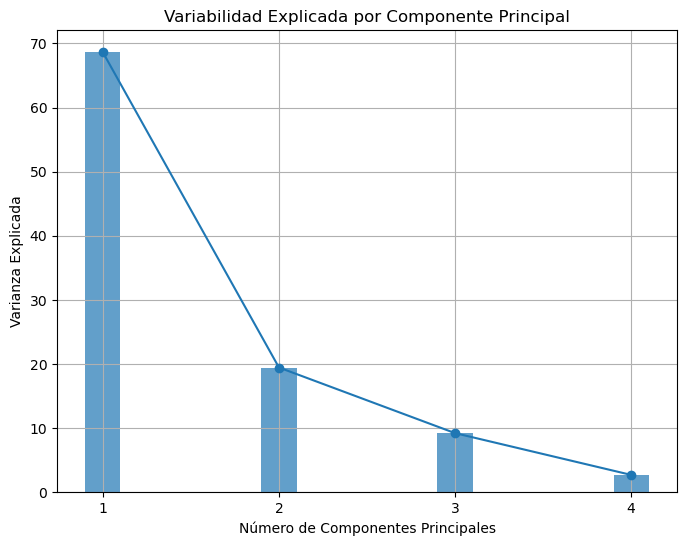

In [16]:
# Gráfico de "Codo"
def plot_varianza_explicada(var_explicada, n_components):
    """
    Representa la variabilidad explicada por cada componente principal
    Args:
      var_explicada (array): Un array que contiene el porcentaje de varianza explicada
        por cada componente principal. Generalmente calculado como
        var_explicada = fit.explained_variance_ratio_ * 100.
      n_components (int): El número total de componentes principales.
        Generalmente calculado como fit.n_components.
    """  
    num_componentes_range = np.arange(1, n_components + 1)

    plt.figure(figsize=(8, 6))

    plt.plot(num_componentes_range, var_explicada, marker='o')

    plt.xlabel('Número de Componentes Principales')
    plt.ylabel('Varianza Explicada')

    plt.title('Variabilidad Explicada por Componente Principal')

    plt.xticks(num_componentes_range)

    plt.grid(True)

    plt.bar(num_componentes_range, var_explicada, width=0.2, align='center', alpha=0.7)

    plt.show()
    
plot_varianza_explicada(var_explicada, fit.n_components_)

Tal y como podemos observar en el dataframe generado o en el gráfico de la varianza explicada por cada componente principal, confirmamos el resultado augurado de que la primera componente ya explica casi la totalidad de la varianza en el conjunto de datos. No obstante, procurando mejorar la capacidad explicativa de esta nueva elección de variables, vamos a tomar las 2 primeras componentes principales que se han generado (esta elección es subjetiva).

Una vez que hemos tomado esta decisión de quedarnos con solo las dos primeras componentes principales, vamos a calcular de nuevo los autovectores asociados (ahora con la información de trabajar solo con 2 componentes).

In [18]:
# PCA con 2 componentes
pca = PCA(n_components=2)
fit = pca.fit(datos_norm)

# Definimos autovalores
autovalores = fit.explained_variance_

# Definimos autovectores
autovectores = pd.DataFrame(pca.components_.T, 
                            columns = ['Autovector {}'.format(i) for i in range(1, fit.n_components_+1)],
                            index = ['{}_z'.format(variable) for variable in variables])
autovectores

,Autovector 1,Autovector 2
bill_length_mm_z,0.453753,0.600195
bill_depth_mm_z,-0.399047,0.796170
flipper_length_mm_z,0.576825,0.005788
body_mass_g_z,0.549675,0.076464


La información recogida en el dataframe generado se puede entender como las siguientes relaciones entre las componentes principales y las variables normalizadas originales:

$$CP_1 = 0.453753 * BillLength_{z} - 0.399047 * BillDepth_{z} + 0.576825 * FlipperLength_{z} + 0.549675 * BodyMass_{z}$$
$$CP_2 = 0.600195 * BillLength_{z} - 0.796170 * BillDepth_{z} + 0.005788 * FlipperLength_{z} + 0.076464 * BodyMass_{z}$$

Así, por ejemplo, el primer valor de la primera componente principal se obtendría tal que:

$$CP_1 = 0.453753 * (-0.896042) - 0.399047 * 0.780732 +  0.576825 * (-1.426752) + 0.549675 * (-0.568475) = -1.853593$$

De hecho, vamos a agrupar todos estos valores en otro Dataframe

In [20]:
# Cálculo de los valores de las componentes principales
resultados_pca = pd.DataFrame(fit.transform(datos_norm), 
                              columns=['Componente {}'.format(i) for i in range(1, fit.n_components_+1)],
                              index=datos_norm.index)

# Dataframe con variables normalizadas y componentes principales elegidas
datos_z_cp = pd.concat([datos_norm, resultados_pca], axis=1)
datos_z_cp

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,Componente 1,Componente 2
0,-0.896042,0.780732,-1.426752,-0.568475,-1.853593,0.032069
1,-0.822788,0.119584,-1.069474,-0.506286,-1.316254,-0.443527
2,-0.676280,0.424729,-0.426373,-1.190361,-1.376605,-0.161230
3,-1.335566,1.085877,-0.569284,-0.941606,-1.885288,-0.012351
4,-0.859415,1.747026,-0.783651,-0.692852,-1.919981,0.817598
...,...,...,...,...,...,...
328,0.587352,-1.762145,0.931283,0.892957,1.997716,-0.976771
329,0.514098,-1.457000,1.002739,0.799674,1.832651,-0.784510
330,1.173384,-0.744994,1.502928,1.919069,2.751505,0.266556
331,0.221082,-1.202712,0.788372,1.234995,1.713854,-0.725875


<div style="width: 100%; text-align: center; font-size: 24px; font-weight: bold;">
    Relación entre variables y componentes principales<br>
</div>
<br>

A continuación se estudiará la relación entre las variables originales (las normalizadas) y las componentes principales. Para ello, formaremos en primer lugar la matriz de correlaciones entre las varaibles y las componentes.

A modo de ejemplo se calculará numéricamente la correlación entre la primera componente principal y la variable referente a la longitud del pico. Se tiene que:

$$ Corr(CP_{i}, X_{j}) = e_{ij}\frac{\sqrt{\lambda_{i}}}{S_{j}} = 0.453753\frac{\sqrt{2.753625}}{1.001505} = 0.751829$$

In [22]:
# Nombre de las columnas del último dataframe generado
datos_cp = datos_z_cp.columns
datos_cp

# Número de variables
n_variables = fit.n_features_in_
n_variables

# Matriz de correlaciones (obviamos la de covarianzas)
Correlaciones_var_comp = datos_z_cp.corr()
Correlaciones_var_comp = Correlaciones_var_comp.iloc[:fit.n_features_in_, fit.n_features_in_:]
Correlaciones_var_comp

,Componente 1,Componente 2
bill_length_mm_z,0.751829,0.529438
bill_depth_mm_z,-0.661186,0.702309
flipper_length_mm_z,0.955748,0.005106
body_mass_g_z,0.910762,0.067449


Nótese que la primera componente está íntimamente relacionada con la longitud de la aleta y la masa corporal de los pingüinos, mientras que la segunda componente practicamente no contribuye a estas variables. Por otra parte, parece que ambas componentes tienen una funcionalidad similar a la hora de representar la variabilidad de las dimensiones referentes al pico de los pingüinos.

Si elevamos estos valores de los coeficientes de correlación entre componentes y variables al cuadrado obtenemos lo que se conoce como "cosenos cuadrados" y que representan la proporción de variabilidad que explica cada componente de cada variable.

In [24]:
cos2 = Correlaciones_var_comp**2
cos2

,Componente 1,Componente 2
bill_length_mm_z,0.565247,0.280304
bill_depth_mm_z,0.437167,0.493237
flipper_length_mm_z,0.913454,0.000026
body_mass_g_z,0.829488,0.004549


La suma de los valores de cada fila del dataframe anterior da cuenta de la cantidad de variabilidad de cada variable que queda representada por las componentes principales. Así, por ejemplo, vemos que la variable mejor representada es la profundidad del pico y la peor la masa corporal:

$$ Corr^{2}(CP_{1}, X_{2}) + Corr^{2}(CP_{2}, X_{2}) = 0.437167 + 0.493237 = 0.930404 $$
$$ Corr^{2}(CP_{1}, X_{4}) + Corr^{2}(CP_{2}, X_{4}) = 0.829488 + 0.004549 = 0.834037 $$

No obstante, esta información es más fácil de apreciar en representaciones gráficas como las que veremos a continuación.

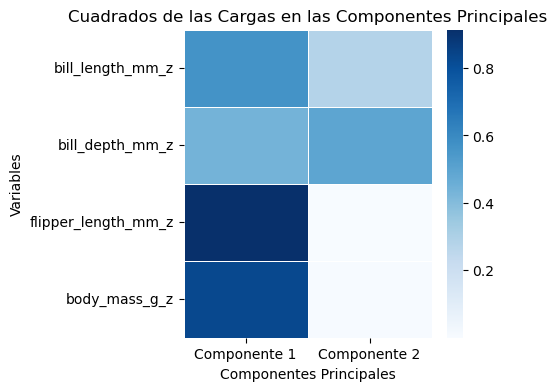

In [26]:
# Contribución de cada componente principale a la varianza de cada variable (Heatmap)
def plot_cos2_heatmap(cosenos2):
    """
    Genera un mapa de calor (heatmap) de los cuadrados de las cargas en las Componentes Principales (cosenos al cuadrado).

    Args:
        cosenos2 (pd.DataFrame): DataFrame de los cosenos al cuadrado, donde las filas representan las variables y las columnas las Componentes Principales.

    """
    plt.figure(figsize=(4, 4))
    sns.heatmap(cosenos2, cmap='Blues', linewidths=0.5, annot=False)
    plt.xlabel('Componentes Principales')
    plt.ylabel('Variables')
    plt.title('Cuadrados de las Cargas en las Componentes Principales')
    plt.show()

plot_cos2_heatmap(cos2)

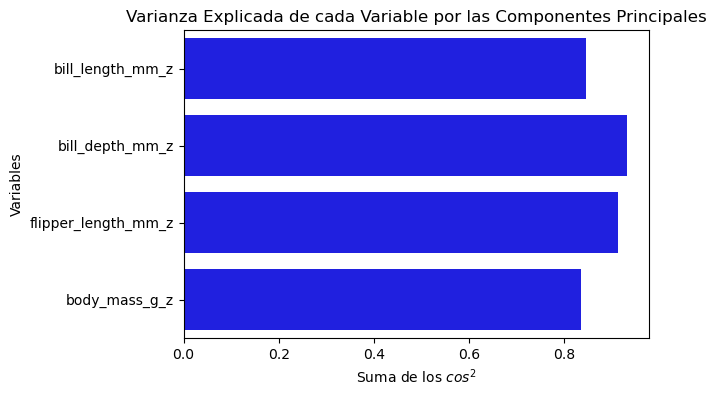

In [27]:
# Varianza explicada de cada variable por el conjunto de componentes principales (Diagrama de barras)
def plot_cos2_bars(cos2):
    """
    Genera un gráfico de barras para representar la varianza explicada de cada variable utilizando los cuadrados de las cargas (cos^2).

    Args:
        cos2 (pd.DataFrame): DataFrame que contiene los cuadrados de las cargas de las variables en las componentes principales.

    Returns:
        None
    """
    plt.figure(figsize=(6, 4))
    sns.barplot(x=cos2.sum(axis=1), y=cos2.index, color="blue")
    plt.xlabel('Suma de los $cos^2$')
    plt.ylabel('Variables')
    plt.title('Varianza Explicada de cada Variable por las Componentes Principales')
    plt.show()
    
plot_cos2_bars(cos2)

Como podemos comprobar, las dos representaciones gráficas que acabos de obtener verifican lo ya augurado acerca de la relación entre las componentes principales y las variables originales. En efecto, la variable que hace referencia a la profundidad del pico de los pingüinos es la más representada por el conjunto de componentes y la que hace referencia a la masa corporal es la que menos representación tiene. No obstante, vemos que la varianza de todas las variables queda suficientemente representada por el conjunto de las componentes. Por otra parte, también se confirma el hecho de que la primera componente principal alude mayoritariamente a las características referentes a la masa corporal y la longitud de la aleta, mientras que la segunda componente principal solo hace referencia directa a las características del pico de los pingüinos.

Veamos a continuación una representación gráfica que engloba un poco a las dos anteriores. Por un lado, nos muestra la información de la relevancia de cada componente principal en la explicación de las distintas variables y, por otra parte, nos habla de la variabilidad explicada por el conjunto de las componentes.

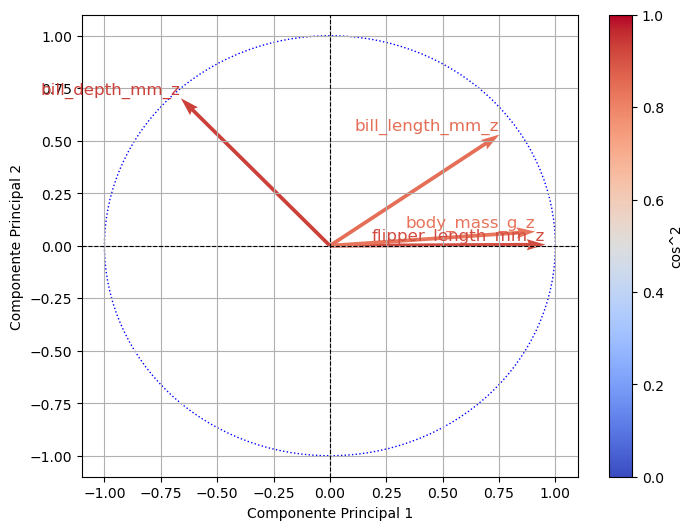

In [29]:
# Gráfico de varianza de las variables explicada por el conjunto de componentes y,
# simultáneamente, varianza de las variables explicada por cada componente principal.
def plot_corr_cos(n_components, correlaciones_datos_con_cp):
    """
    Genera un gráfico en el que se representa un vector por cada variable, usando como ejes las componentes, la orientación
    y la longitud del vector representa la correlación entre cada variable y dos de las componentes. El color representa el
    valor de la suma de los cosenos al cuadrado.
    
    Args:
        n_components (int): Número entero que representa el número de componentes principales seleccionadas.
        correlaciones_datos_con_cp (DataFrame): DataFrame que contiene la matriz de correlaciones entre variables y componentes
    """
    cmap = plt.get_cmap('coolwarm')   
    for i in range(n_components):
        for j in range(i + 1, n_components):
            sum_cos2 = correlaciones_datos_con_cp.iloc[:, i] ** 2 + correlaciones_datos_con_cp.iloc[:, j] ** 2
            fig, ax = plt.subplots(figsize=(8, 6))
            circle = plt.Circle((0, 0), 1, fill=False, color='b', linestyle='dotted')
            ax.add_patch(circle)
            for k, var_name in enumerate(correlaciones_datos_con_cp.index):
                x = correlaciones_datos_con_cp.iloc[k, i]
                y = correlaciones_datos_con_cp.iloc[k, j]
                color = cmap(sum_cos2.iloc[k])
                ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color=color)
                ax.text(x, y, var_name, color=color, fontsize=12, ha='right', va='bottom')
            ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
            ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
            ax.set_xlabel(f'Componente Principal {i + 1}')
            ax.set_ylabel(f'Componente Principal {j + 1}')
            ax.set_xlim(-1.1, 1.1)
            ax.set_ylim(-1.1, 1.1)
            sm = plt.cm.ScalarMappable(cmap=cmap)
            sm.set_array([])  # Evita errores de escala
            plt.colorbar(sm, ax=ax, orientation='vertical', label='cos^2')
            plt.grid()
            plt.show()

plot_corr_cos(fit.n_components, Correlaciones_var_comp)

En efecto, corroboramos una vez más que las variables que hacen referencia al pico de los pingüinos tienen una justificación compartida entre ambas componentes principales, mientras que las variables referentes a la masa corporal y la longitud de la aleta guardan relación mayoritariamente con la primera componente principal (además es una influencia positiva). Comprobamos también, tanto por el color de los vectores como por su cercanía al círculo de radio unidad, que la variabilidad de todas las variables están suficientemente representada por la contribución conjunta de ambas componentes principales.

Para concluir con esta parte referente a la relación entre variables y componentes, veamos ahora, en lugar de la varianza de las variables explicada por cada componente principal, la contribución porcentual de cada variable a las diferentes componentes principales. Para ello haremos un gráfico de calor similar al primero de esta sección.

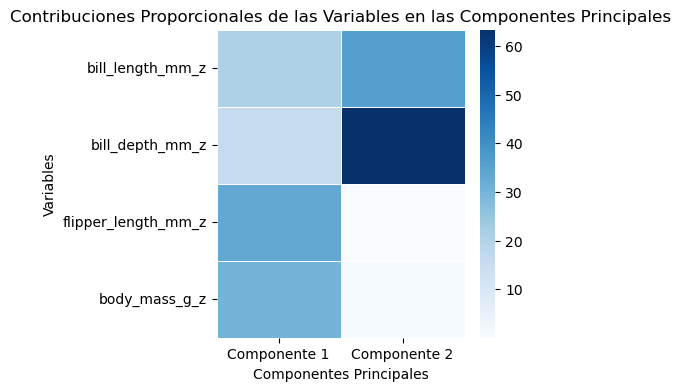

In [31]:
# Contribución de cada variable a las diferentes componentes principales (Heatmap)
def plot_contribuciones_proporcionales(cos2, autovalores, n_components):
    """
    Cacula las contribuciones de cada variable a las componentes principales y
    Genera un gráfico de mapa de calor con los datos
    Args:
        cos2 (DataFrame): DataFrame de los cuadrados de las cargas (cos^2).
        autovalores (array): Array de los autovalores asociados a las componentes principales.
        n_components (int): Número de componentes principales seleccionadas.
    """
    contribuciones = cos2 * np.sqrt(autovalores)
    sumas_contribuciones = []
    for i in range(n_components):
        nombre_componente = f'Componente {i + 1}'
        suma_contribucion = np.sum(contribuciones[nombre_componente])
        sumas_contribuciones.append(suma_contribucion)
    contribuciones_proporcionales = contribuciones.div(sumas_contribuciones, axis=1) * 100

    plt.figure(figsize=(4, 4))
    sns.heatmap(contribuciones_proporcionales, cmap='Blues', linewidths=0.5, annot=False)
    plt.xlabel('Componentes Principales')
    plt.ylabel('Variables')
    plt.title('Contribuciones Proporcionales de las Variables en las Componentes Principales')
    plt.show()
    
    # Devuelve los DataFrames de contribuciones y contribuciones proporcionales
    return contribuciones_proporcionales

contribuciones_proporcionales = plot_contribuciones_proporcionales(cos2,autovalores,fit.n_components)

Concluimos este apartado de relaciones entre variables originales (normalizadas) y componentes principales verificando, una vez más, lo comentado en celdas anteriores.

<div style="width: 100%; text-align: center; font-size: 24px; font-weight: bold;">
    Representación de los registros en la nueva base de coordenadas<br>
</div>
<br>

A continuación, y para concluir con el análisis de PCA, vamos a proceder con una representación gráfica de cada uno de los registros de las base de datos inicial en el nuevo marco de las coordenadas $PC_{1}$ y $PC_{2}$. Además, se incluirá también una representación vectorial de la contribución de cada componente principal a cada una de las variables, tal y como veíamos en un gráfico anterior.

Sin embargo, previo a todo esto, vamos a añadir a este estudio la variable categórica que hace referencia a la especie del pingüino en cuestión.

In [33]:
# Añadimos la variable especie al conjunto de datos
datos_species_islas = pd.concat([datos_z_cp, species, island], axis = 1)
datos_species_islas

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,Componente 1,Componente 2,species,island
0,-0.896042,0.780732,-1.426752,-0.568475,-1.853593,0.032069,Adelie,Torgersen
1,-0.822788,0.119584,-1.069474,-0.506286,-1.316254,-0.443527,Adelie,Torgersen
2,-0.676280,0.424729,-0.426373,-1.190361,-1.376605,-0.161230,Adelie,Torgersen
3,-1.335566,1.085877,-0.569284,-0.941606,-1.885288,-0.012351,Adelie,Torgersen
4,-0.859415,1.747026,-0.783651,-0.692852,-1.919981,0.817598,Adelie,Torgersen
...,...,...,...,...,...,...,...,...
328,0.587352,-1.762145,0.931283,0.892957,1.997716,-0.976771,Gentoo,Biscoe
329,0.514098,-1.457000,1.002739,0.799674,1.832651,-0.784510,Gentoo,Biscoe
330,1.173384,-0.744994,1.502928,1.919069,2.751505,0.266556,Gentoo,Biscoe
331,0.221082,-1.202712,0.788372,1.234995,1.713854,-0.725875,Gentoo,Biscoe


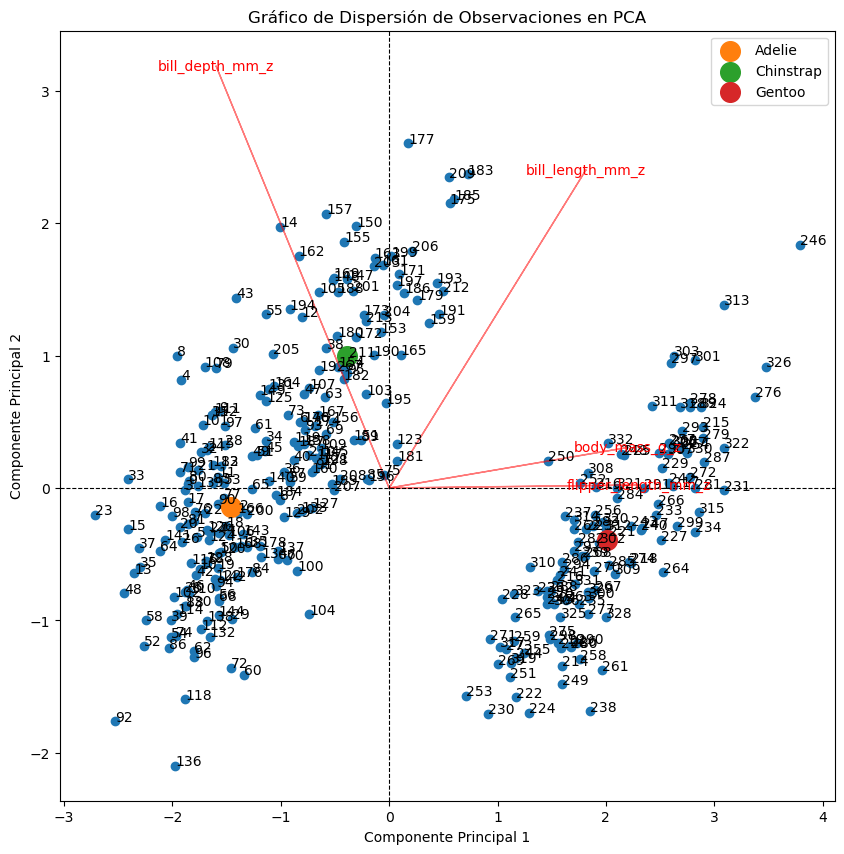

In [34]:
# Scatter plot de cada registro en la base {CP_1, CP_2}, representación vectorial de
# contribuciones a cada variable y centroides de la variable especies.
def plot_pca_scatter_with_categories(datos_componentes_sup_var, componentes_principales_sup, n_components, var_categ):
    """
    Genera gráficos de dispersión de observaciones en pares de componentes principales seleccionados con categorías.

    Args:
        datos_componentes_sup_var (pd.DataFrame): DataFrame que contiene las categorías.
        componentes_principales_sup (np.ndarray): Matriz de componentes principales.
        n_components (int): Número de componentes principales seleccionadas.
        var_categ (str): Nombre de la variable introducida
    """
    # Obtener las categorías únicas
    categorias = datos_componentes_sup_var[var_categ].unique()

    # Iterar sobre todos los posibles pares de componentes principales
    for i in range(n_components):
        for j in range(i + 1, n_components):
            # Crear un gráfico de dispersión de las observaciones en las dos primeras componentes principales
            plt.figure(figsize=(10, 10))
            plt.scatter(componentes_principales_sup[:, i], componentes_principales_sup[:, j])

            for categoria in categorias:
                # Filtrar las observaciones por categoría
                observaciones_categoria = componentes_principales_sup[datos_componentes_sup_var[var_categ] == categoria]
                # Calcular el centroide de la categoría
                centroide = np.mean(observaciones_categoria, axis=0)
                plt.scatter(centroide[i], centroide[j], label=categoria, s=200, marker='o')

            # Añadir etiquetas a las observaciones
            etiquetas_de_observaciones = list(datos_componentes_sup_var.index)

            for k, label in enumerate(etiquetas_de_observaciones):
                plt.annotate(label, (componentes_principales_sup[k, i], componentes_principales_sup[k, j]))

            # Dibujar líneas discontinuas que representen los ejes
            plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
            plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

            # Etiquetar los ejes
            plt.xlabel(f'Componente Principal {i + 1}')
            plt.ylabel(f'Componente Principal {j + 1}')

            # Establecer el título del gráfico
            plt.title('Gráfico de Dispersión de Observaciones en PCA')

            #Representación de vectores para las variables
            fit = pca.fit(datos_norm)
            coeff = np.transpose(fit.components_)
            scaled_coeff = 4 * coeff  #8 = escalado utilizado, ajustar en función del ejemplo
            for var_idx in range(scaled_coeff.shape[0]):
                plt.arrow(0, 0, scaled_coeff[var_idx, i], scaled_coeff[var_idx, j], color='red', alpha=0.5)
                plt.text(scaled_coeff[var_idx, i], scaled_coeff[var_idx, j],
                     datos_norm.columns[var_idx], color='red', ha='center', va='center')

            # Mostrar la leyenda para las categorías
            plt.legend()
            plt.savefig('scatter.png')
            plt.show()
            
plot_pca_scatter_with_categories(datos_species_islas, resultados_pca.values, fit.n_components, 'species')

Nótese que las especies están agrupadas de manera bastante diferenciada en el espacio de coordenadas definido por la base {$CP_{1}, CP_{2}$}. Vemos que los pingüinos de la especie "Gentoo" (color rojo) se encuentran principalmente desplazados hacia valores positivos de la componente principal $CP_{1}$, lo cual sugiere que tienen una mayor masa corporal y longitud de aleta. Por el contrario, los pingüinos de las especies "Chinstrap" (color verde) y "Adelie" (color naranja) distan bastante de los "Gentoo" en la dirección de la componente $CP_{1}$, aunque poco entre ellos. Sin embargo, sí que se observa una diferencia mayor entre estas especies en la dirección de la componente principal $CP_{2}$, la cual recordamos que está relacionada con características físicas del pico de las aves.

La información anterior da a entender que los pingüinos de la especie "Gentoo" tienen mayor masa corporal y una aleta más grande que las otras dos especies. Por otra parte, las especies "Chinstrap" y "Adelie" tienen masas corporales y tamaños de aletas similares. Para estas dos especies parece haber diferencias más significativas entre sus picos. Concretamente, parece que la especie "Chinstrap" tendrá valores de longitud y profundidad del pico mayores que la especie "Adelie".

<div style="width: 100%; text-align: center; font-size: 32px; font-weight: bold;">
    Análisis Clustering<br>
</div>
<br>
<div style="width: 100%; text-align: center; font-size: 24px; font-weight: bold;">
    Análisis jerárquico<br>
</div>
<br>
Para comenzar con esta técnica de análisis, el primer paso será estandarizar los datos (lo cual ya se hizo en celdas anteriores: "datos_norm"). Una vez tenemos los datos normalizados, se procederá a calcular la matriz de distancias.

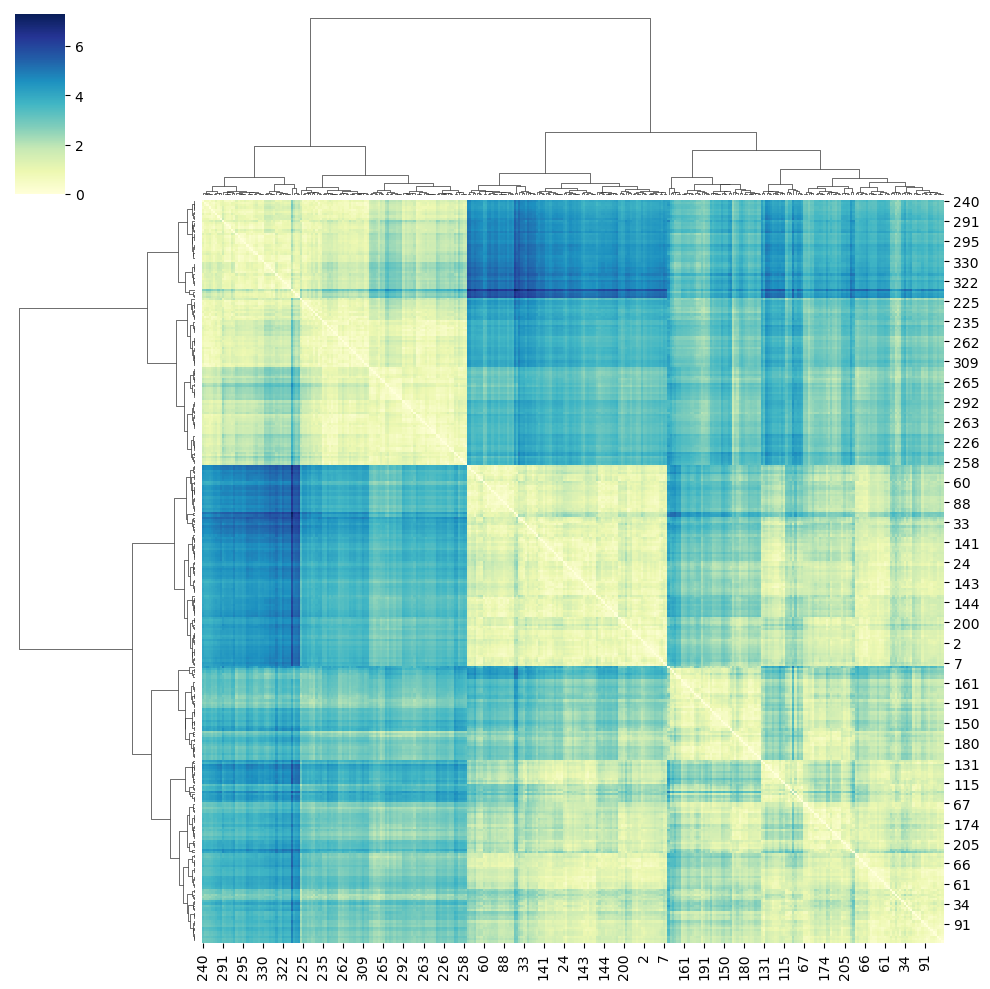

In [36]:
# Generamos la matriz de distancias euclideas entre cada par de
# pingüinos y mostramos las primeras 10x10 visualizaciones
distance_z = distance.cdist(datos_norm, datos_norm, 'euclidean')
df_distance_z = pd.DataFrame(distance_z, index = datos_norm.index, columns = datos_norm.index)

# Generamos un mapa de calor para estas distancias que incluya
# un clustering jerárquico
linkage = sns.clustermap(df_distance_z, cmap="YlGnBu", fmt=".1f", annot=False, method='ward').dendrogram_row

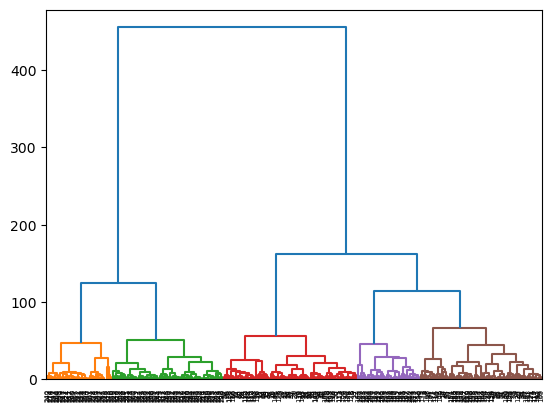

In [37]:
# Generamos también el dendrograma de clustering pero sin el mapa de calor
color_threshold = 75
linkage_matrix = sch.linkage(df_distance_z, method='ward')
dendrogram = sch.dendrogram(linkage_matrix, labels=df_distance_z.index.tolist(), leaf_rotation=90, color_threshold=color_threshold)

Como se puede observar, ya el mapa de calor muestra una cierta diferenciación en grupos o clústers en lo que respecta a la distancia euclídea entre las medidas de cada pingüino. Por otra parte, analizando el dendrograma por separado (realizado con el algoritmo de Ward), vemos que 5 parece un número razonable de clústers para este estudio. Este hecho se basa en que el siguiente nivel de agrupación realizado por el algoritmo ya se hace a una altura considerablemente mayor.

A continuación, teniendo en cuenta la decisión anterior de considerar 5 clústers, vamos a añadir al DataFrame de los datos normalizados una columna correspondiente al clúster asociado para cada pingüino. Esto nos va a permitir reciclar el análisis de las PCA para hacer un scatter plot en las componentes principales que habíamos generado pero diferenciado cada registro según el clúster al que pertenece.

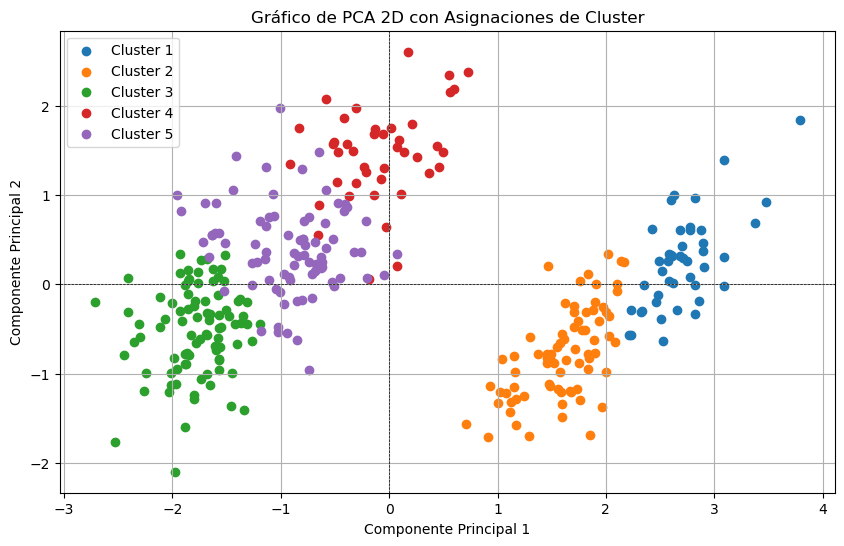

In [39]:
# Asignamos las observaciones de datos a 5 clusters
num_clusters = 5
cluster_assignments = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
datos_norm['Cluster'] = cluster_assignments

plt.figure(figsize=(10, 6))  # Establecemos el tamaño del gráfico

# Recorremos las asignaciones únicas de clusters y trazamos puntos de datos con el mismo color
for cluster in np.unique(cluster_assignments):
    cluster_indices = resultados_pca.loc[cluster_assignments == cluster].index
    plt.scatter(resultados_pca.loc[cluster_indices, 'Componente 1'],
                resultados_pca.loc[cluster_indices, 'Componente 2'],
                label=f'Cluster {cluster}')  # Etiqueta para cada cluster

# Líneas de referencia para los ejes x e y
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)

plt.title("Gráfico de PCA 2D con Asignaciones de Cluster")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid()
plt.show()

Como se puede apreciar, se ha optado por suprimir la etiqueta de los índices de cada registro para una mejor visualización de la información. Vemos claramente la diferenciación en los 5 clúster predefinidos. Respecto a la información física de los pingüinos que se puede obtener de aquí, nada nuevo con respecto a lo comentado en el análisis PCA. Posteriormente, cuando se haga un proceso de clustering no jerárquico y se discuta el número óptimo de agrupamientos, podremos hablar sobre la calidad de los mismos, así como de su significancia en relación con la especie o el lugar de procedencia de los pingüinos, lo cual constituye el siguiente paso en este Notebook.

<div style="width: 100%; text-align: center; font-size: 24px; font-weight: bold;">
    Análisis NO jerárquico<br>
</div>
<br>

A continuación, con el objetivo de seleccionar el número de clústers óptimos para el análisis, vamos a aplicar el método del codo y el método de la silueta. Esto nos permitirá contrastar con la decisión tomada por la simple visualización del dendrograma anterior (clustering jerárquico) y el mapa de calor.

  File "C:\Users\jacob\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


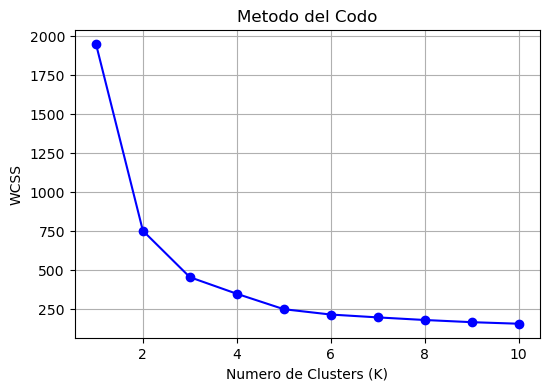

In [41]:
# Método del codo
# Creamos un array para almacenar los valores de WCSS para diferentes valores de K
wcss = []
    
for k in range(1, 11):  # Puedes elegir un rango diferente de valores de K
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(datos_norm)
    wcss.append(kmeans.inertia_)  # Inserta es el valor de WCSS

# Graficamos los valores de WCSS frente al numero de grupos (K) y buscamos el punto "codo"
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Metodo del Codo')
plt.xlabel('Numero de Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

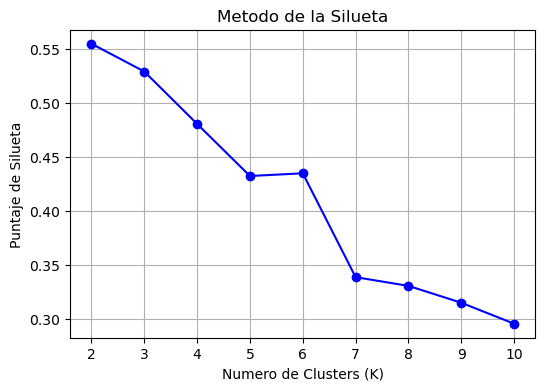

In [42]:
# Método de la silueta
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(datos_norm)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(datos_norm, labels)
    silhouette_scores.append(silhouette_avg)
    
# Graficamos los puntajes de silueta frente al numero de clusters (K)
plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Metodo de la Silueta')
plt.xlabel('Numero de Clusters (K)')
plt.ylabel('Puntaje de Silueta')
plt.grid(True)
plt.show()

Tras la implementación de los dos métodos anteriores podemos argumentar lo siguiente. Por un lado, el método del codo establece que a partir de 3 o 4 clústers la diferencia en el parámetro WCSS deja de ser significativa. Por otra parte, el método de la silueta nos ofrece el mayor máximo local con 3 clústers.

Nótese que este resultado es disonante con nuestra conclusión previa al realizar el análisis jerárquico, donde parecía que el resultado óptimo sería diferenciar en 5 aglomeraciones diferentes. Sin embargo, atendiendo a estos dos últimos métodos y al análisis de PCA realizado anteriormente donde incluíamos los centroides de cada especie, parace que la decisión más acertada para la elección del número de clústers va a ser de 3.

Tomando entonces este número de clúster (k = 3) como el óptimo, vamos a aplicar un algoritmo K-means no jerárquico para la definición final de los clústers a considerar.

In [44]:
# Análisis no jerárquico (K-means)
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(datos_norm)
kmeans_cluster_labels = kmeans.labels_

<div style="width: 100%; text-align: center; font-size: 24px; font-weight: bold;">
    Evaluación de la calidad de las agrupaciones<br>
</div>
<br>
A continuación, vamos a estudiar la calidad de las agrupaciones que hemos formado. Para ello, vamos a realizar una representación gráfica del coeficiente de silueta para cada registro de cada clúster.

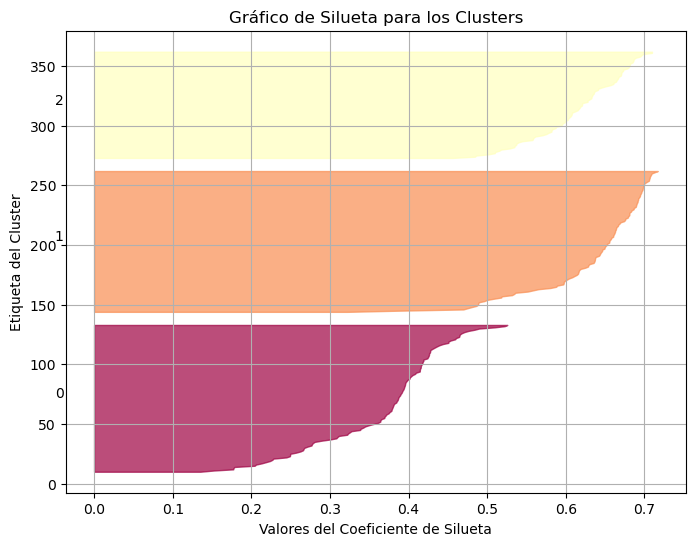

In [46]:
# Calculamos los valores de silueta para cada observación
silhouette_values = silhouette_samples(datos_norm, kmeans.labels_)
    
# Configuramos el tamaño de la figura para el gráfico
plt.figure(figsize=(8, 6))
y_lower = 10  # Inicio del margen inferior en el gráfico

# Iteramos sobre los 3 clusters para calcular los valores de silueta y dibujar el gráfico
for i in range(3):
    # Extraemos los valores de silueta para las observaciones en el cluster i
    ith_cluster_silhouette_values = silhouette_values[kmeans.labels_ == i]
    # Ordenamos los valores para que el gráfico sea más claro
    ith_cluster_silhouette_values.sort()
    
    # Calculamos donde terminarán las barras de silueta en el eje y
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Elegimos un color para el cluster
    color = plt.cm.get_cmap("Spectral")(float(i) / 4)
    # Rellenamos el gráfico entre un rango en el eje y con los valores de silueta
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    # Etiquetamos las barras de silueta con el número de cluster en el eje y
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Actualizamos el margen inferior para el siguiente cluster
    y_lower = y_upper + 10  # 10 para el espacio entre clusters

# Títulos y etiquetas para el gráfico
plt.title("Gráfico de Silueta para los Clusters")
plt.xlabel("Valores del Coeficiente de Silueta")
plt.ylabel("Etiqueta del Cluster")
plt.grid(True)  # Añadimos una cuadrícula para mejor legibilidad
plt.show()  # Mostramos el gráfico resultante

Del gráfico anterior podemos concluir que la agrupación realizada es bastante correcta, pues ningún valor del coeficiente de silueta es negativo y, de hecho, son todos valores relativamente altos. Esto augura que cada pingüino se ha categorizado en un clúster de forma que se garantiza una diferencia significativa con los pingüinos de los otros dos clústers.

Usando ahora esta colección (supuesta óptima) de clústers, vamos a volver a realizar la representación gráfica de scattering usando como base las componentes principales obtenidas en el análisis PCA y diferenciado por clústers. Además, se representarán también los centroides de las especies y la isla de procedencia de cada pingüino.

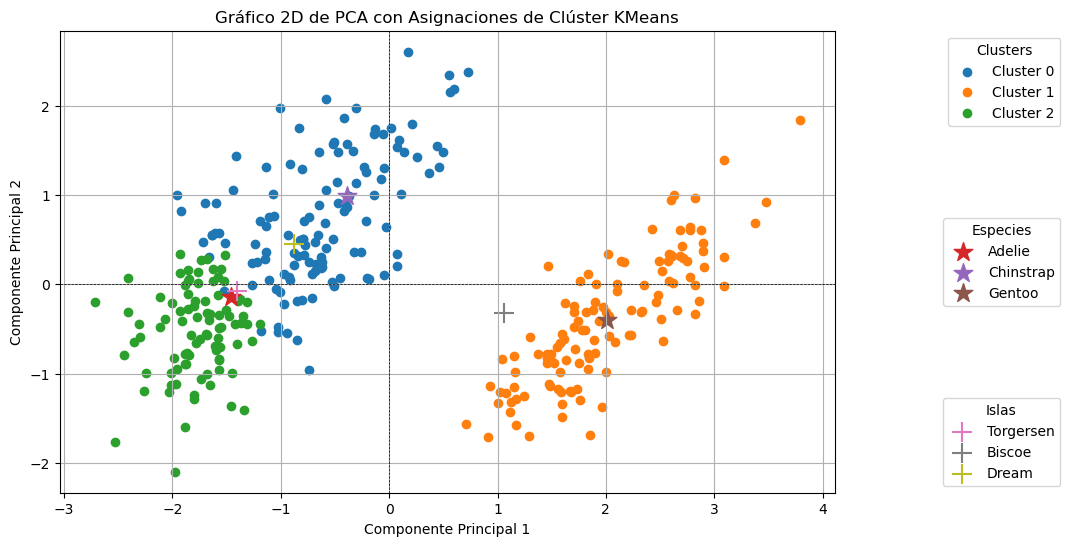

In [48]:
plt.figure(figsize=(10, 6))  # Definir el tamaño de la figura

# Listas para almacenar handles y labels de cada categoría
handles_clusters, labels_clusters = [], []
handles_species, labels_species = [], []
handles_islands, labels_islands = [], []

# Iterar a través de las etiquetas únicas de clusters y graficar puntos de datos con el mismo color
for cluster in np.unique(kmeans_cluster_labels):
    cluster_indices = resultados_pca.loc[kmeans_cluster_labels == cluster].index
    scatter = plt.scatter(resultados_pca.loc[cluster_indices, 'Componente 1'],
                          resultados_pca.loc[cluster_indices, 'Componente 2'],
                          label=f'Cluster {cluster}')
    handles_clusters.append(scatter)
    labels_clusters.append(f'Cluster {cluster}')

# Centroide de especies
dist_species = species['species'].unique()
for spe in dist_species:
    observaciones_categoria = resultados_pca.values[datos_species_islas['species'] == spe]
    centroide = np.mean(observaciones_categoria, axis=0)
    scatter = plt.scatter(centroide[0], centroide[1], label=spe, s=200, marker='*')
    handles_species.append(scatter)
    labels_species.append(spe)

# Centroide de islas
dist_islas = island['island'].unique()
for isla in dist_islas:
    observaciones_categoria = resultados_pca.values[datos_species_islas['island'] == isla]
    centroide = np.mean(observaciones_categoria, axis=0)
    scatter = plt.scatter(centroide[0], centroide[1], label=isla, s=200, marker='+')
    handles_islands.append(scatter)
    labels_islands.append(isla)

# Líneas de referencia para los ejes x e y
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Configurar el título y las etiquetas de los ejes del gráfico
plt.title("Gráfico 2D de PCA con Asignaciones de Clúster KMeans")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()  # Mostrar la cuadrícula

# Crear las tres leyendas
legend1 = plt.legend(handles_clusters, labels_clusters, title="Clusters", loc="upper right", bbox_to_anchor=(1.3, 1))
legend2 = plt.legend(handles_species, labels_species, title="Especies", loc="center right", bbox_to_anchor=(1.3, 0.5))
legend3 = plt.legend(handles_islands, labels_islands, title="Islas", loc="lower right", bbox_to_anchor=(1.3, 0))

# Añadir las leyendas a la figura
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.show()  # Mostrar el gráfico

Como se aprecia en el gráfico anterior, vemos que los centroides de las islas de procedencia y de las especies guarda una relación significativa con la agrupación en los distintos clúster obtenidos por los métodos previos. Concretamente, vemos que esta correspondencia es ligeramente mayor en referencia a la especie que a la isla de procedencia.

Para concluir con este estudio, vamos a considerar hacer un análisis de la media de las variables originales agrupando por clúster.

In [50]:
datos_num['Cluster'] = kmeans_cluster_labels
datos_sort = datos_num.sort_values(by = 'Cluster')
cluster_centroids_orig = datos_sort.groupby('Cluster').mean()
cluster_centroids_orig.round(2)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
Cluster,,,,
0,45.10,18.80,195.75,3933.67
1,47.57,15.00,217.24,5092.44
2,37.73,17.78,186.64,3413.06


Tal y como habíamos augurado previamente con el análisis PCA, vemos que los pingüinos pertenecientes al clúster 0 y 2 (los que tienen una tendencia negativa en la dirección de la componente principal PC1) tienen valores significativamente menores de masa corporal y longitud de aleta con respecto a los pertenecientes al clúster 1. Por otra parte, entre los individuos del clúster 0 y 2, donde no se aprecia una diferencia notable en los valores referentes a la masa corporal o la longitud de la aleta, vemos que sí hay una diferencia notable principalmente en la longitud del pico.

Concluimos con lo anterior que la agrupación en estos tres clúster parece adecuada atendiendo tanto a su similitud con la especie de los pingüinos como a las diferencias notorias entre los elementos de una agrupación y las demás.